# Seminal Work: Classification of objects with deposit using a RaspberryPi
Autoren: Sofie Scharaf, Dominic Viola

## Step 0: Prerequisits

In [1]:
!python --version

Python 3.10.6


In [278]:
# prerequisits
!pip install numpy pandas opencv-python keras tensorflow tensorboard # if on Apple silicon also use this: tensorflow-metal

In [1]:
# imports and set seed so results are random, but stil reproducable
import tensorflow as tf
import keras
import tensorflow.keras.layers as layers
from sklearn.preprocessing import OneHotEncoder
import random
import os  # Helps you manage files and folders
import sys
import cv2  # Working with images
import numpy as np
import seaborn as sns  # Helps you visualize your discoveries
import matplotlib.pyplot as plt  # To plot images
import datetime


print("tensorflow version: "+ tf.__version__)
print("keras version: ", keras.__version__)

def set_seed(seed=0):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)
  keras.utils.set_random_seed(seed)

set_seed()

tensorflow version: 2.16.1
keras version:  3.3.2


## Step 1: Find Datasets
We want to train a model to recognize and classify different kinds of Cans and bottles.
This will later be used in an IoT system that displays the price one would get for a certain type of can or bottle.

Hence, we need some training data to fine tune an existing model to recognize these classes.
Therefore, we download a dataset that contains can and bottle data, so that we can fine tune a model to recognize and classify them. 
Later on we may need some real world images of the actual cans we want to use our system on.

The CIFAR-100 dataset has come classes in the food_container superclass, that may be interesting for this use-case:
- bottles 
- cans 
- cups

See https://www.cs.toronto.edu/~kriz/cifar.html

Considerations that have to be made: 
1. Train only with the relevant classes and then also train with more classes to see if it improves the model ?
1. Add an additional class for other objects than cans and bottles to prevent many false positives ?
1. Pointwise Convolution in Model Head?



In [2]:
# download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")

In [3]:
label_names = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [4]:
# select the classes we want
train_labels = [label_names[int(idx)] for idx in y_train]
test_labels = [label_names[int(idx)] for idx in y_test]
test_labels

/var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/ipykernel_39155/939403219.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_labels = [label_names[int(idx)] for idx in y_train]
/var/folders/f_/mtgsl6n13zd4n7z20x96lx1m0000gn/T/ipykernel_39155/939403219.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_labels = [label_names[int(idx)] for idx in y_test]


['mountain',
 'forest',
 'seal',
 'mushroom',
 'sea',
 'tulip',
 'camel',
 'butterfly',
 'cloud',
 'apple',
 'sea',
 'skunk',
 'streetcar',
 'rocket',
 'lamp',
 'lion',
 'tulip',
 'wolf',
 'rose',
 'orange',
 'rose',
 'mountain',
 'skunk',
 'dinosaur',
 'chimpanzee',
 'can',
 'keyboard',
 'bicycle',
 'bicycle',
 'rose',
 'chair',
 'plate',
 'lawn_mower',
 'turtle',
 'palm_tree',
 'shark',
 'pickup_truck',
 'boy',
 'couch',
 'house',
 'porcupine',
 'cockroach',
 'mountain',
 'shark',
 'palm_tree',
 'clock',
 'lawn_mower',
 'pickup_truck',
 'skunk',
 'castle',
 'beaver',
 'bee',
 'bottle',
 'pear',
 'baby',
 'flatfish',
 'sea',
 'oak_tree',
 'leopard',
 'rocket',
 'snail',
 'crocodile',
 'camel',
 'rabbit',
 'beetle',
 'girl',
 'lion',
 'sunflower',
 'porcupine',
 'tulip',
 'raccoon',
 'train',
 'ray',
 'trout',
 'flatfish',
 'flatfish',
 'sunflower',
 'bowl',
 'snail',
 'clock',
 'sea',
 'snake',
 'orchid',
 'bee',
 'dinosaur',
 'tractor',
 'snake',
 'forest',
 'boy',
 'ray',
 'clock',


<BarContainer object of 100 artists>

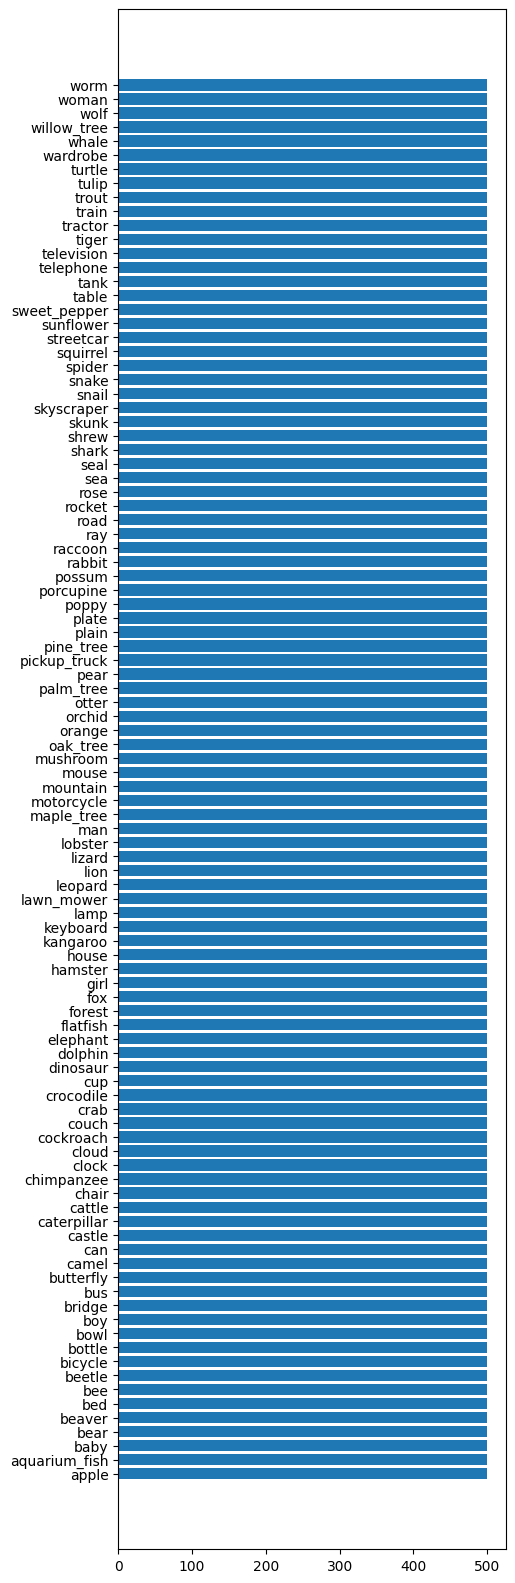

In [5]:
# see how many instances of each class there are
values, counts  = list(np.unique(train_labels, return_counts=True))
class_frequency = list(zip(list(values), list(counts)))

plt.figure(figsize=(5, 20))
plt.barh(y=values, width=counts)

The classes are already balanced, so there is no need to modify the balance within the dataset

In [6]:
def filter_classes(classes: list, x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array):
    """
    Filter the dataset for the specified class names from the dataset. All other entries will be droped.
    """
    # normalize labels to create a mask
    norm_y_train = y_train.T[0].tolist()
    norm_y_test = y_test.T[0].tolist()

    # the class ids that are used in y_train, y_test
    select_labels = []
    for class_name in classes:
        assert class_name in label_names, f"The class with the name '{class_name}' doesnt exist."
        select_labels.append(label_names.index(class_name))
    
    # select train data points
    train_mask = np.isin(norm_y_train, select_labels)
    
    # select test data points
    test_mask = np.isin(norm_y_test, select_labels)

    return x_train[train_mask], y_train[train_mask], x_test[test_mask], y_test[test_mask]

x_train, y_train, x_test, y_test = filter_classes(["can", "bottle", "cup"], x_train, y_train, x_test, y_test)

In [7]:
def convert_label_ids_to_names(y):
    """
    Converts the ids to the associated label names in the original dataset. Those are not one-hot-labels.

    Input:
    ---
    y: the labels in index form; The index corresponds to the class name as a string in the label_names variable

    Output:
    ---
    output: list of string names of the classes
    """
    output = []
    for l in range(len(y)):
        output.append(label_names[y.T[0][l]])
    return output

#print(y_test)
print(list(zip(y_test, convert_label_ids_to_names(y_test))))

[(array([16]), 'can'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([16]), 'can'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([28]), 'cup'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([16]), 'can'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([16]), 'can'), (array([28]), 'cup'), (array([9]), 'bottle'), (array([9]), 'bottle'), (array([28]), 'cup'), (array([16]), 'can'), (array([28]), 'cup'), (array([28]), 'cup'), (array([28]), 'cup'), (array([16]), 'can'), (array([9]), 'bottle'), (

In [8]:
def labels_to_one_hot(y_train: np.array, y_test:np.array):
    """
    Takes in the class id labels and converts them to one-hot encoded representations.

    output:
    ---
    one_hot_train: One Hot encoded version of the first input 
    one_hot_test: One Hot encoded version of the second input
    categories: A list of the label names; the index in the one hot entry in a vector is equivalent to the index of the corresponding label name in this list
    """
    # preprocess to label names instead of label ids
    y_train_labels = convert_label_ids_to_names(y_train)
    y_test_labels = convert_label_ids_to_names(y_test)

    # to avoid giving the y_train and y_test different one hot locations for the same class, we will combine them into one vector and split them up again afterwards, so the one-hot vectors are consistent between train and test
    y_combined = np.concatenate([y_train_labels, y_test_labels])
    # create a second dimension since OneHotEncoder requires 2D input 
    y_combined = y_combined.reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False) #dont use sparse vectors as the output
    y_combined_encoded = encoder.fit_transform(y_combined)
    
    #print(encoder.categories_)

    #split the combined array into train and test labels again
    split_idx = len(y_train)
    one_hot_train, one_hot_test = np.split(y_combined_encoded, [split_idx])
    #print(one_hot_train)

    assert len(one_hot_train) == len(y_train), "Length missmatch between train and one_hot_train"
    assert len(one_hot_test) == len(y_test), "Length missmatch between test and one_hot_test"
    return one_hot_train, one_hot_test, encoder.categories_[0] #categories is shape 1xnum_categories so we need to read 0 to remove the first dim

In [9]:
def one_hot_to_labels(y, categories):
    """
    Input
    ---
    y: The one hot labels of shape num_classes X num_examples
    categories: The categories that the OneHotEncoder returned to convert the one-hot-positions to the corresponding label name

    Output
    ---
    out: The labels y but converted from the one-hot representation to the label names container in categories
    """
    label_idxs = np.argmax(y, axis = 1)
    #print("argmax", label_idxs)
    #print("categories", categories)
    out = []
    for idx in label_idxs:
        out.append(categories[idx])
    return out


In [10]:
one_hot_train, one_hot_test, hot_idx_to_label = labels_to_one_hot(y_train, y_test)

# validate that everything works as intended
orig = convert_label_ids_to_names(y_train)
decoded = one_hot_to_labels(one_hot_train, hot_idx_to_label)
print("Len:", len(orig), len(decoded))
print("original X one-hot\n", list(zip(orig, decoded)))

Len: 1500 1500
original X one-hot
 [('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('can', 'can'), ('bottle', 'bottle'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('cup', 'cup'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('can', 'can'), ('can', 'can'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('bottle', 'bottle'), ('can', 'can'), ('cup', 'cup'), ('bottle', 'bottle'), ('cup', 'cup'), ('can', 'can'), ('can', 'can'), ('cup', 'cup'), ('cup', 'cup'), ('bottle',

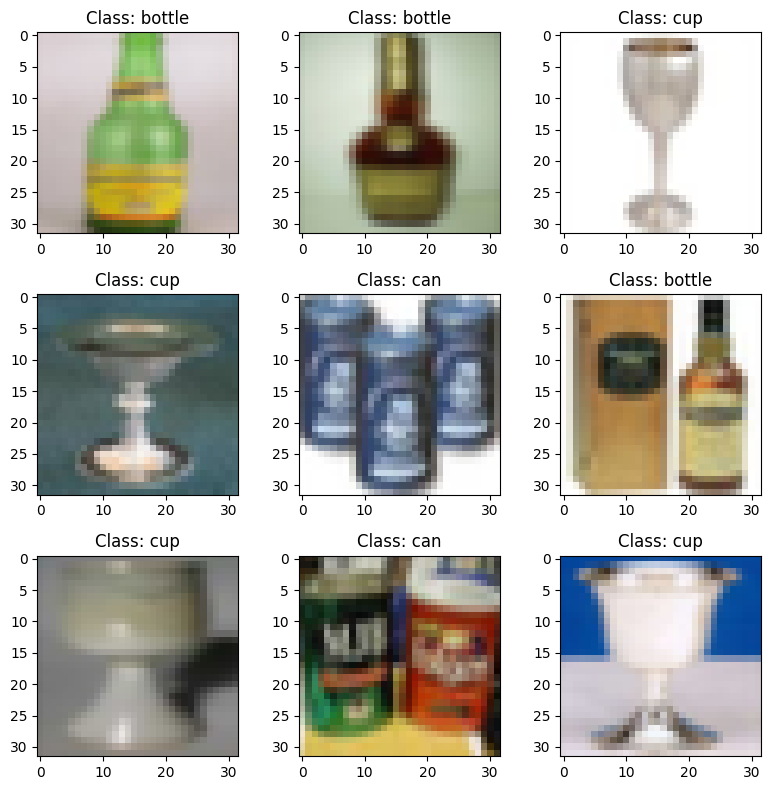

In [11]:
# visualize the remaining data
fig, ax = plt.subplots(3,3)
fig.set_size_inches(8,8)
for i in range(3):
    for j in range (3):
        l = random.randint(0, len(y_test))
        ax[i,j].imshow(x_test[l])
        ax[i,j].set_title('Class: ' + label_names[y_test.T[0][l]])

plt.tight_layout()

## Step 2: Create a Data Augmentation pipeline

In [12]:
pipeline_in = layers.Input(shape=(32,32,3))
pipeline = layers.RandomFlip("horizontal_and_vertical")(pipeline_in)
pipeline = layers.RandomRotation(0.2)(pipeline)
pipeline = layers.RandomZoom((0, -0.25))(pipeline) #zooms in horizontal and vertical direction and preserves aspect ratio
pipeline_out = layers.RandomBrightness((-0.2, 0.2), value_range=[0, 255], dtype=tf.int16)(pipeline) # increase and decrease between 20%
# output datatype cannot be unsigned int, because the clipping of the RandomBrightness will not be bale to handle overflow of the color channels, but if there is a negative range the clipping works

augmentation_pipeline = keras.Model(pipeline_in, pipeline_out)

2024-07-09 14:18:16.993337: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-09 14:18:16.993360: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-09 14:18:16.993405: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-09 14:18:16.993439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-09 14:18:16.993455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


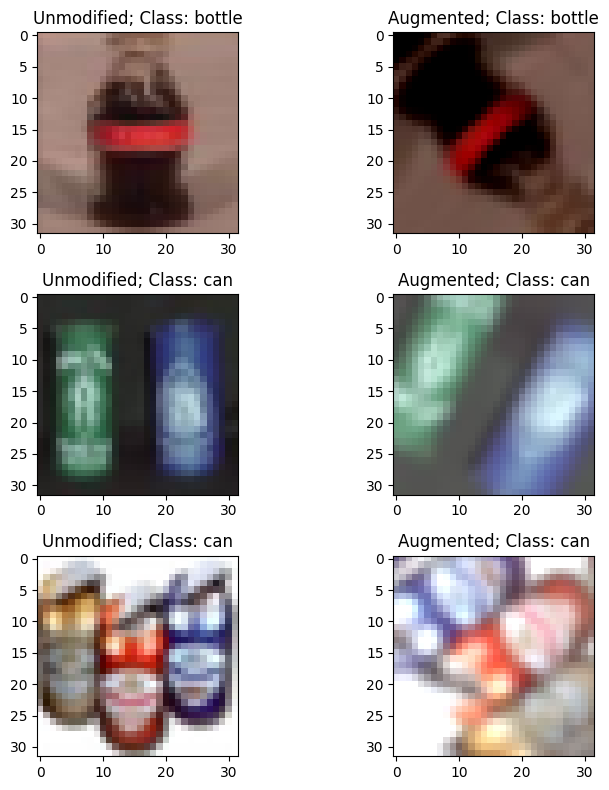

In [13]:
# test the data augmentation pipeline

fig, ax = plt.subplots(3,2)
fig.set_size_inches(8,8)
for i in range(3):
    l = random.randint(0, len(y_test)-1)
    sample = x_test[l]
    #print("Original:", sample)
    ax[i,0].imshow(sample)
    ax[i,0].set_title('Unmodified; Class: ' + label_names[y_test.T[0][l]])

    augmented = augmentation_pipeline(sample[None, :]) # add batch dim (required by the model)
    augmented = np.squeeze(augmented) # remove batch dimenstion (required by matplotlib)
    #print("augmented:", augmented)
    ax[i,1].imshow(augmented)
    ax[i,1].set_title('Augmented; Class: ' + label_names[y_test.T[0][l]])

plt.tight_layout()

## Step 3: Select a backbone
Since the model will be deployed on a RaspberryPi we need a model with few parameters to respect the constraints of the IoT device.

In [14]:
input_shape = (32, 32, 3)

# select the backbone model that will be placed on the Raspberry Pi
mobile_net_backbone = keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    alpha=1.0,
    minimalistic=False,
    include_top=False, #remove the head; only use as backbone
    weights="imagenet",
    input_tensor=None,
    #classes=3, # cup, bottle, can

    pooling=None,
    dropout_rate=0.2,
    #classifier_activation="softmax",
    include_preprocessing=True,
)


/Users/dom/miniconda3/envs/images/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [15]:
# freeze backbone
mobile_net_backbone.trainable = False

# construct the workflow for fine-tuning
input_layer = keras.Input(shape=input_shape, dtype=tf.uint8, name="Input")
x = augmentation_pipeline(input_layer)
x = mobile_net_backbone(x, training=False) #set model to inference and its weights to be non-trainable
# head
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(3, activation="softmax")(x) # cup, bottle, can


# create model with the head
model = keras.Model(input_layer, output)

In [21]:
# to use the CategoricalCrossentropy we need to convert our labels into one hot encoded representation, instead of the indices of the class
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [123]:
model.summary()
mobile_net_backbone.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 1, 1, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │         2,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 32, 32, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 16, 16,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 16, 16,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 16, 16,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 17, 17,    │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 8, 8, 64)  │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

## Step 4: Fine-Tune and Transfer Learning
Now we use our cup, bottle and can data to fine tune the new model head that we have attached to our MobileNetV3 backbone. 
Afterwards we will fine tune the entire model weights.

In [30]:
# conversion to one-hot representation is needed by CategoricalCrossEntropy
one_hot_train, one_hot_test, hot_idx_to_label = labels_to_one_hot(y_train, y_test)

def train_model(model: keras.Model = None, checkpoint_name: str = None, load_from_checkpoint: bool = True, 
                epochs: int = 10, patience: int = 50, monitored_metric: str ='val_loss'):
    """
    Train a model object from scratch or continue training it from a checkpoint in the checkpoints folder.
    Parameters for early stopping and saving the resulting model to a checkpoint can be set. 
    The checkpoint created will have the filetype ".keras" and fill be post-fixed with the number of epochs trained.

    NOTE: 
    - either model or checkpoint_name must be defined. If checkpoint is provided and found in "checkpoints" folder while "load_from_checkpoint" is true the provided model variable will be ignored.
    - Dont use "_" or ".keras" in the name of checkpoints these might break the checkpointing logic.

    Input:
    ---
    model: the keras.Model that should be trained, optional if a checkpoint is provided
    checkpoint_name: the name of a checkpoint without the epoch prefix and file_format. If the checkpoint does not exist it will be created after the model variable was trained.
    load_from_checkpoints: set this to false if you only want to use the checkpoint for saving the final model, but not to load from an existing checkpoint. Ignore this if you do not use "checkpoint_name".
    epochs: num of epochs the model should be trained
    patience: patience in the early stopping process
    monitored_metric: the metric that will be used to determined early stopping and the best model checkpoint

    Output:
    ---
    model: the trained model instance
    history: the training history, which can be used to visualize the training process
    """
    assert model is not None or checkpoint_name is not None, "Error: Either model or checkpoint_name must be defined!"

    # vars
    goal_epochs = epochs

    #####################
    ## Load Checkpoint ##
    #####################
    # load latest checkpoint is checkpoint name exists and load_from_checkpoint is true
    os.makedirs("checkpoints", exist_ok=True)
    checkpoints = os.listdir("checkpoints")
    if checkpoints != [] and load_from_checkpoint and checkpoint_name is not None:
        highest_epoch = 0
        highest_checkpoint = ""
        for checkpoint_full in checkpoints:
            if checkpoint_full.startswith(checkpoint_name):
                try:
                    curr_checkpoint_name, curr_checkpoint_format = checkpoint_full.split(".")
                    if curr_checkpoint_format == "keras":
                        current_epoch = int(curr_checkpoint_name.split("_")[-1])
                        if current_epoch > highest_epoch:
                            highest_epoch = current_epoch
                            highest_checkpoint = checkpoint_full
                except:
                    continue
        if highest_checkpoint != "":
            goal_epochs = epochs + highest_epoch
            print("Loading Model from checkpoint:", highest_checkpoint)
            model = keras.saving.load_model(f"checkpoints/{highest_checkpoint}")
            results = model.evaluate(x_test, one_hot_test)
            print("Loaded model performance on eval data:", results)

    assert model is not None, "Error: You did not specify a model as input and it was not possible to load a model from checkpoint!"

    ###############
    # Train Model #
    ###############
    # callbacks during training process
    early_stop_cb  = tf.keras.callbacks.EarlyStopping(monitor=monitored_metric, patience=patience)
    
    output_checkpoint = f"checkpoints/{checkpoint_name}_{goal_epochs}.keras"
    check_point_cb = tf.keras.callbacks.ModelCheckpoint(output_checkpoint, monitor=monitored_metric, save_best_only=True)

    log_dir = f"logs/fit/{checkpoint_name}/{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}"
    os.makedirs(log_dir, exist_ok=True)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq="epoch")

    history = model.fit(
        x=x_train, y=one_hot_train, epochs=epochs, 
        validation_data=(x_test, one_hot_test), 
        callbacks=[early_stop_cb, check_point_cb, tensorboard_callback]
    )


    return model, history

In [31]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
 %reload_ext tensorboard

In [33]:
%tensorboard --logdir logs/fit/mobileNetV3Large-FullyConnected

Reusing TensorBoard on port 6006 (pid 45174), started 0:06:48 ago. (Use '!kill 45174' to kill it.)

In [35]:
model, history = train_model(model, "mobileNetV3Large-FullyConnected", epochs=100)

Loading Model from checkpoint: mobileNetV3Large-FullyConnected_20.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - categorical_accuracy: 0.6340 - loss: 0.8677
Loaded model performance on eval data: [0.8685604929924011, 0.6200000047683716]
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - categorical_accuracy: 0.6254 - loss: 0.8370 - val_categorical_accuracy: 0.6133 - val_loss: 0.8759
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - categorical_accuracy: 0.5977 - loss: 0.9087 - val_categorical_accuracy: 0.6167 - val_loss: 0.8755
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - categorical_accuracy: 0.6157 - loss: 0.8637 - val_categorical_accuracy: 0.6200 - val_loss: 0.8576
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - categorical_accuracy: 0.6348 - loss: 0.8473 - val_categorical_accuracy: 0.6300 - val_loss: 0.8577
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - categorical_accuracy: 0.6172 - loss: 0.8496 - val_categorical_accuracy: 0.6167 - val_loss: 0.868

In [297]:
max_val_f1 = 0
for tensor in history.history['val_f1_score']:
    for val in tensor.numpy():
        if val > max_val_f1:
            max_val_f1 = val

TypeError: 'History' object is not subscriptable

In [204]:
# list the data captured by the history
print(history.history.keys())
print("Best val_accuracy:", max(history.history['val_categorical_accuracy'])*100, "%")
print("Best Val F1 score", max_val_f1*100, "%")
print("Best val_loss:", min(history.history['val_loss']))

dict_keys(['categorical_accuracy', 'f1_score', 'loss', 'val_categorical_accuracy', 'val_f1_score', 'val_loss'])
Best val_accuracy: 61.000001430511475 %
Best Val F1 score 68.10344457626343 %
Best val_loss: 0.8847994208335876


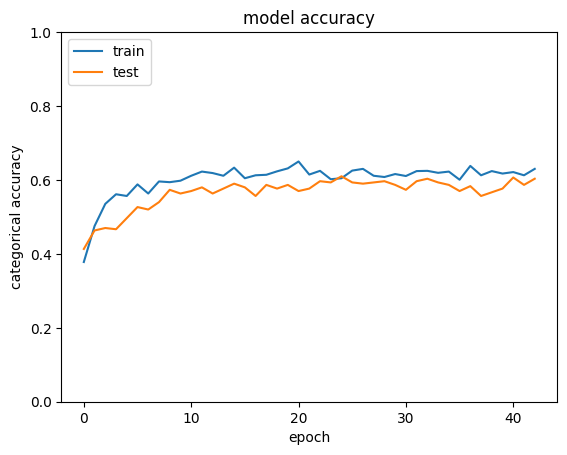

In [206]:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.gca().set_ylim(bottom=0, top=1.0)
plt.show()


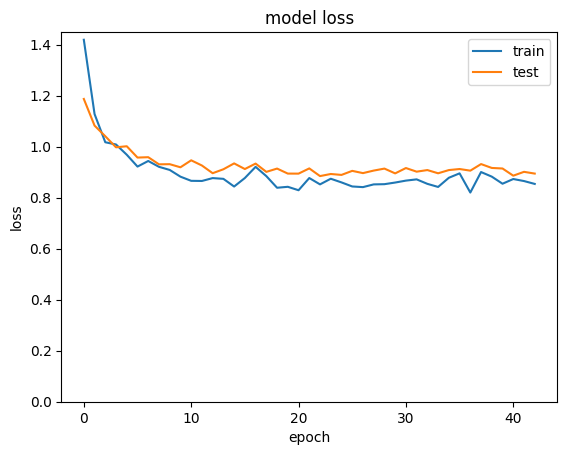

In [209]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.gca().set_ylim(bottom=0)
plt.show()

Maybe we could train the head for even more epochs?